# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [33]:
df_hourly = pd.read_csv('../data/interim/df_hourly.csv', parse_dates=[0], index_col=0)

In [34]:
df_hourly.columns

Index(['Shark Meter, KWH', 'AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Month',
       'Hour', 'Year'],
      dtype='object')

### Average Energy for Month of Year and Hour of Day

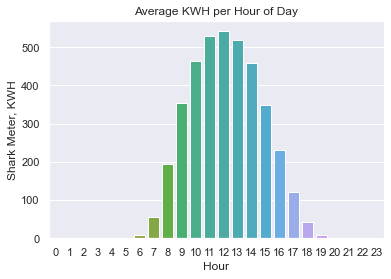

In [35]:
KWH_by_hour = df_hourly[['Shark Meter, KWH','Hour']].groupby(by='Hour').mean().reset_index()
sns.barplot(data=KWH_by_hour, x='Hour',y='Shark Meter, KWH')
plt.title('Average KWH per Hour of Day');

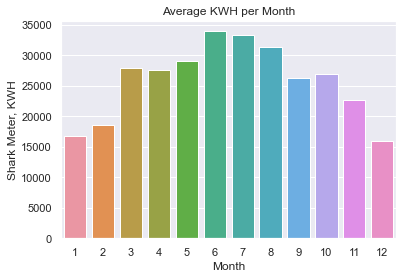

In [36]:
# First group by month and year summing the energy, then take the mean
KWH_by_monthyear = df_hourly[['Shark Meter, KWH','Month','Year']].groupby(by=['Month','Year']).sum().reset_index()
KWH_by_month = KWH_by_monthyear[['Shark Meter, KWH','Month']].groupby(by='Month').mean().reset_index()
sns.barplot(data=KWH_by_month, x='Month',y='Shark Meter, KWH')
plt.title('Average KWH per Month');

We can see the strong hourly and yearly patterns in terms of energy output.  

### Seasonal Decomposition

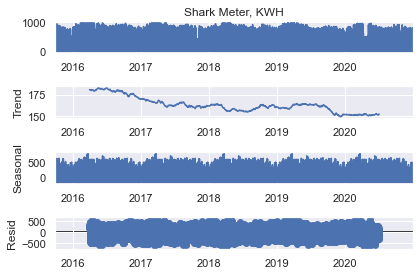

In [41]:
decomp = seasonal_decompose(df_hourly['Shark Meter, KWH'], period=24*365, model = 'add')
decomp.plot();

It's really hard to see the seasonality here because the data is so noisy, so let's try this again with a rolling average.  

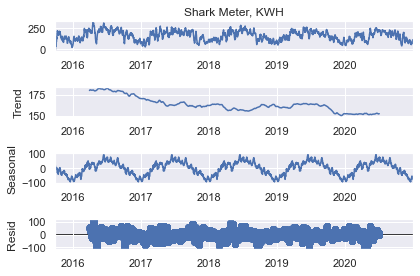

In [46]:
df_hourly_rolling_7D = df_hourly['Shark Meter, KWH'].rolling(window='7D').mean()
decomp = seasonal_decompose(df_hourly_rolling_7D, period=24*365, model = 'add')
decomp.plot();

Now we clearly see the seasonality, the downward trend as the solar cells degrade.  We also see that the residuals are still quite large.  

### ACF and PACF

Let's try to make the data staionary and then plot the ACF and PACF.

In [52]:
diff_hourly_rolling_7D = df_hourly_rolling_7D.diff(periods=1)
diff_hourly_rolling_7D.dropna(inplace=True)

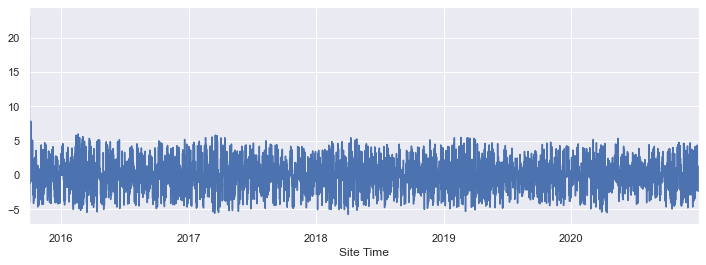

In [53]:
diff_hourly_rolling_7D.plot(figsize=(12,4));

That looks pretty stationary! 

In [55]:
adfuller(diff_hourly_rolling_7D)

(-25.241486545219043,
 0.0,
 54,
 46000,
 {'1%': -3.43049216662936,
  '5%': -2.8616028346100526,
  '10%': -2.5668034448057657},
 81296.5632058183)

The ADFuller test shows a p-value of 0, so we can reject the null hypothesis and conclude that our differenced time series is now stationary. Let's plot the ACF and PACF again.

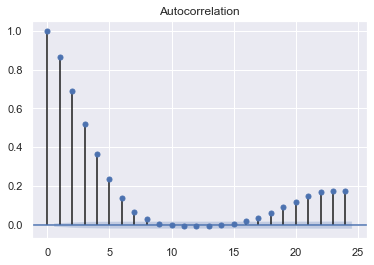

In [58]:
plot_acf(diff_hourly_rolling_7D, lags=24);

We can see the autocorrelation corresponding to the hours of the day.  

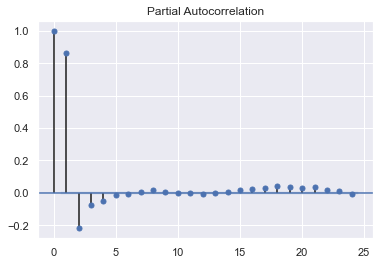

In [59]:
plot_pacf(diff_hourly_rolling_7D, lags=24);